In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import pickle
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
import random
from matplotlib.pylab import rcParams
from datetime import datetime,timedelta
%matplotlib inline
rcParams['figure.figsize'] = 10,6

In [2]:
data = pd.read_csv('Data/Indonesia.csv')

In [3]:
data = data[['date','total_deaths']]
data['date']= pd.to_datetime(data['date'],infer_datetime_format = True)
indexedDataset = data.set_index(['date'])

In [4]:
indexedDataset.head()
indexedDataset = indexedDataset[indexedDataset.total_deaths != 0]

In [5]:
indexedDataset.tail()

,total_deaths
date,
2020-12-17,19390.0
2020-12-18,19514.0
2020-12-19,19659.0
2020-12-20,19880.0
2020-12-21,20085.0


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


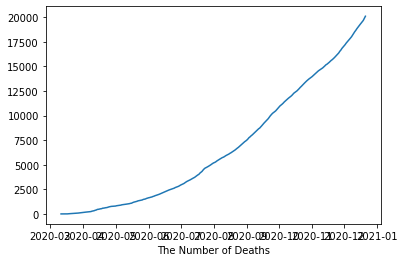

In [6]:
plt.xlabel("Date")
plt.xlabel("The Number of Deaths")
plt.plot(indexedDataset)

## Rolling Statistics

In [7]:
rolmean = indexedDataset.rolling(window=30).mean()
rolstd = indexedDataset.rolling(window=30).std()
print(rolmean,rolstd)

            total_deaths
date                    
2020-03-11           NaN
2020-03-12           NaN
2020-03-13           NaN
2020-03-14           NaN
2020-03-15           NaN
...                  ...
2020-12-17  17318.700000
2020-12-18  17452.400000
2020-12-19  17587.700000
2020-12-20  17727.766667
2020-12-21  17871.466667

[286 rows x 1 columns]             total_deaths
date                    
2020-03-11           NaN
2020-03-12           NaN
2020-03-13           NaN
2020-03-14           NaN
2020-03-15           NaN
...                  ...
2020-12-17   1209.518603
2020-12-18   1223.497350
2020-12-19   1235.954780
2020-12-20   1250.090581
2020-12-21   1265.441472

[286 rows x 1 columns]


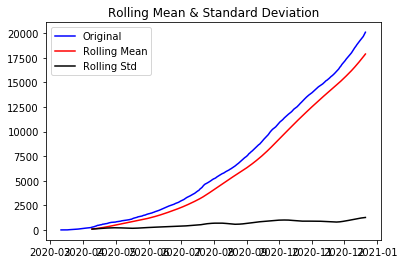

In [8]:
orig = plt.plot(indexedDataset, color='blue',label='Original')
mean = plt.plot(rolmean, color='red',label='Rolling Mean')
std = plt.plot(rolstd, color='black',label='Rolling Std')

plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show(block=False)

# Conclusion : Data is not stationary

In [9]:
indexedDataset

,total_deaths
date,
2020-03-11,1.0
2020-03-12,1.0
2020-03-13,4.0
2020-03-14,5.0
2020-03-15,5.0
...,...
2020-12-17,19390.0
2020-12-18,19514.0
2020-12-19,19659.0


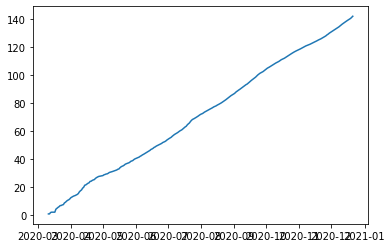

In [10]:
indexedDataset_logScale = np.sqrt(indexedDataset)
plt.plot(indexedDataset_logScale)

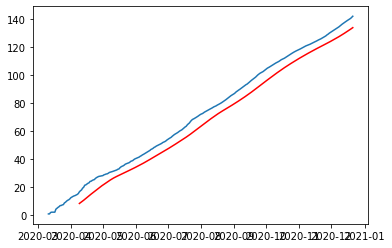

In [11]:
movingAverage = indexedDataset_logScale.rolling(window=30).mean()
movingSTD = indexedDataset_logScale.rolling(window=30).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage,color='red')

In [12]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(30)

datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,total_deaths
date,
2020-04-09,8.293562
2020-04-10,8.503455
2020-04-11,8.524303
2020-04-12,9.177263
2020-04-13,9.247742
2020-04-14,10.057436
2020-04-15,9.642213
2020-04-16,9.589030
2020-04-17,9.506661


In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def test_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=30).mean()
    movingSTD = timeseries.rolling(window=30).std()
    
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red',label='Rolling Mean')
    std = plt.plot(movingSTD, color='black',label='Rolling Std')

    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    
    print("Dicket-Fuller Evaluation")
    dftest = adfuller(timeseries['total_deaths'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number Of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
    print(dfoutput)

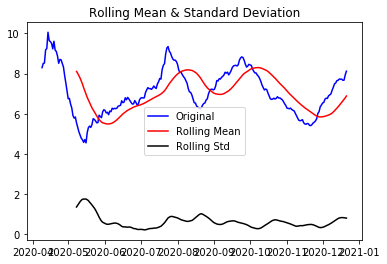

Dicket-Fuller Evaluation
Test Statistic                 -4.506197
p-value                         0.000192
#Lags Used                      5.000000
Number Of Observation Used    251.000000
Critical Value(1%)             -3.456674
Critical Value(5%)             -2.873125
Critical Value(10%)            -2.572944
dtype: float64


In [15]:
test_stationarity(datasetLogScaleMinusMovingAverage)

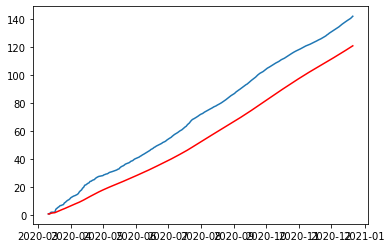

In [16]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife = 30, min_periods=0,adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage,color="red")

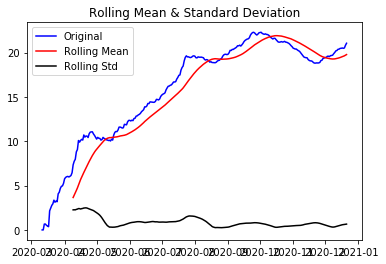

Dicket-Fuller Evaluation
Test Statistic                 -3.816806
p-value                         0.002740
#Lags Used                      5.000000
Number Of Observation Used    280.000000
Critical Value(1%)             -3.453922
Critical Value(5%)             -2.871918
Critical Value(10%)            -2.572300
dtype: float64


In [17]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

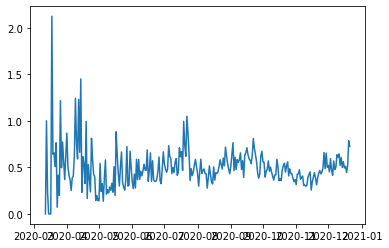

In [18]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

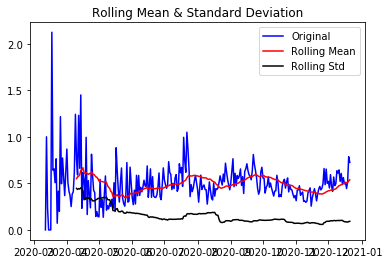

Dicket-Fuller Evaluation
Test Statistic                 -5.310262
p-value                         0.000005
#Lags Used                      4.000000
Number Of Observation Used    280.000000
Critical Value(1%)             -3.453922
Critical Value(5%)             -2.871918
Critical Value(10%)            -2.572300
dtype: float64


In [19]:
datasetLogDiffShifting.dropna(inplace = True)
test_stationarity(datasetLogDiffShifting)

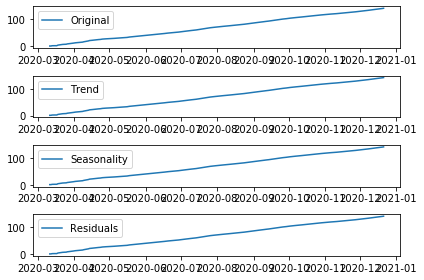

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale,label="Original")
plt.legend(loc="best")

plt.subplot(412)
plt.plot(indexedDataset_logScale,label="Trend")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(indexedDataset_logScale,label="Seasonality")
plt.legend(loc="best")

plt.subplot(414)
plt.plot(indexedDataset_logScale,label="Residuals")
plt.legend(loc="best")
plt.tight_layout()

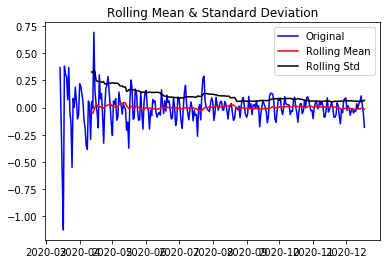

Dicket-Fuller Evaluation
Test Statistic               -8.420656e+00
p-value                       1.987751e-13
#Lags Used                    8.000000e+00
Number Of Observation Used    2.710000e+02
Critical Value(1%)           -3.454713e+00
Critical Value(5%)           -2.872265e+00
Critical Value(10%)          -2.572485e+00
dtype: float64


In [21]:
decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
test_stationarity(decomposedLogData)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


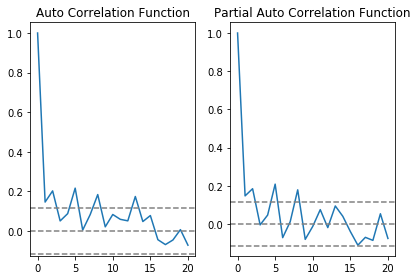

In [22]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetLogDiffShifting,nlags=20)
lag_pacf = pacf(datasetLogDiffShifting,nlags=20,method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color="gray")
plt.title("Auto Correlation Function")

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color="gray")
plt.title("Partial Auto Correlation Function")

plt.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA model


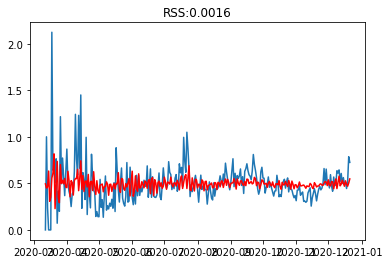

In [23]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues,color="red")
plt.title("RSS:%.4f"% sum(results_ARIMA.fittedvalues-datasetLogDiffShifting['total_deaths'])**2)
print("ARIMA model")

In [24]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

date
2020-03-12    0.494034
2020-03-13    0.449579
2020-03-14    0.460330
2020-03-15    0.632139
2020-03-16    0.307530
dtype: float64


In [25]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2020-03-12    0.494034
2020-03-13    0.943613
2020-03-14    1.403944
2020-03-15    2.036083
2020-03-16    2.343613
dtype: float64


In [26]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['total_deaths'].ix[0],index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value = 0)
predictions_ARIMA_log.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


date
2020-03-11    1.000000
2020-03-12    1.494034
2020-03-13    1.943613
2020-03-14    2.403944
2020-03-15    3.036083
dtype: float64

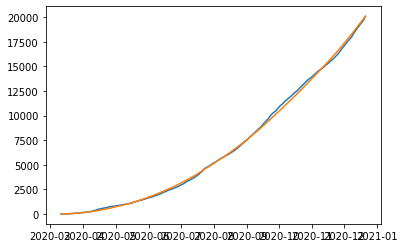

In [27]:
predictions_ARIMA = np.square(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [28]:
indexedDataset_logScale

,total_deaths
date,
2020-03-11,1.000000
2020-03-12,1.000000
2020-03-13,2.000000
2020-03-14,2.236068
2020-03-15,2.236068
...,...
2020-12-17,139.247980
2020-12-18,139.692519
2020-12-19,140.210556


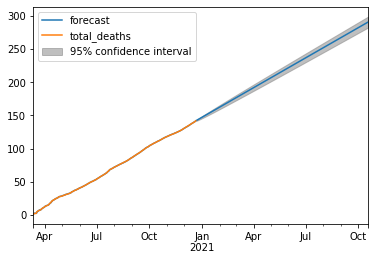

In [29]:
results_ARIMA.plot_predict(1,586)
x = results_ARIMA.forecast(steps = 300)

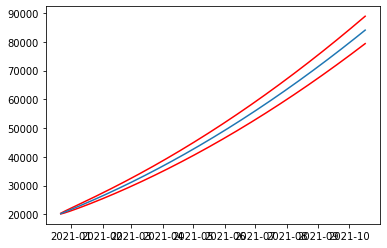

In [30]:
date = []
for i in range(1,301):
    start_date = datetime(2020, 12, 21, 15, 36, 6, 492925) + timedelta(i)
    date.append(pd.to_datetime(start_date.date(),infer_datetime_format = True))
    
plt.plot(date,np.square(x[2]),color="red")
plt.plot(date,np.square(x[0]))
